# Quick Platypus Tokenomics calculation
### wimwam.eth

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator

In [15]:
# protocol-level constants

MAX_SUPPLY = 3 * 10**8                # 300,000,000
LIQUIDITY_MINING_ALLOCATION = 0.4     # 40% of above

BASE_POOL_ALLOCATION = .3
BOOSTING_POOL_ALLOCATION = .5
AVAX_PTP_POOL = .2

HOURLY_STAKED_PTP_vePTP_YIELD = 0.014
MAX_vePTP_TO_STAKED_PTP_RATIO = 30

In [45]:
# market-level constants

CIRCULATING_MARKET_CAP = 10 ** 7      # assume 10MM MC for now
TVL_TO_CMC_RATIO = 5                  # TVL 5x the size of token CMC (curve's TVL is >12x)
TVL = TVL_TO_CMC_RATIO * CIRCULATING_MARKET_CAP

PERCENT_COINS_CIRCULATING = .035 + .035 + LIQUIDITY_MINING_ALLOCATION
PTP_PRICE = CIRCULATING_MARKET_CAP / (MAX_SUPPLY * PERCENT_COINS_CIRCULATING)
FDMC = PTP_PRICE * MAX_SUPPLY

PERCENT_PTP_STAKED = .4
PTP_STAKED = MAX_SUPPLY * PERCENT_COINS_CIRCULATING * PERCENT_PTP_STAKED

print(f"Calculations consider PTP/USD: ${round(PTP_PRICE, 3)}\n" + 
          f"Reflecting a FDMC of \t${round(FDMC / 10**6)}MM " + 
          f"({round(PERCENT_COINS_CIRCULATING * 100)}% of coins available)\n" + 
          f"and implying TVL of \t${round(TVL / 10**6)}MM " + 
          f"(Mcap/TVL: {round(1 / TVL_TO_CMC_RATIO, 4)})\n" + 
          f"with {round(PTP_STAKED / 10**6, 2)}MM PTP staked for vePTP ({round(PERCENT_PTP_STAKED * 100)}%)")

Calculations consider PTP/USD: $0.071
Reflecting a FDMC of 	$21MM (47% of coins available)
and implying TVL of 	$50MM (Mcap/TVL: 0.2)
with 56.4MM PTP staked for vePTP (40%)


In [14]:
# Stablecoin bankroll of 0 to 10,000 USD
STABLES_MIN = 0
STABLES_MAX = 10000
N_STEPS = 100
stable_deposit_range = np.arange(STABLES_MIN, STABLES_MAX, 
                                 (STABLES_MAX - STABLES_MIN) / N_STEPS)

In [22]:
# Allocating some percent of bankroll to market-buying PTP for staking
MIN_BANKROLL_PROPORTION_FOR_PTP = 0
MAX_BANKROLL_PROPORTION_FOR_PTP = 0.2  # Max of 20%
ptp_market_buy_bankroll_proportion = np.arange(MIN_BANKROLL_PROPORTION_FOR_PTP,
                                            MAX_BANKROLL_PROPORTION_FOR_PTP,
                                            MAX_BANKROLL_PROPORTION_FOR_PTP / N_STEPS)

In [47]:
def boosted_pool_emission_rate(your_stable_deposit, vePTP_held, other_deposit_weights):
    your_boosted_pool_weight = np.sqrt(your_stable_deposit * vePTP_held)
    percentage = your_boosted_pool_weight / other_deposit_weights
    return percentage

def base_pool_emission_rate(your_stable_deposit, other_stable_deposits):
    total_deposits = other_stable_deposits + your_stable_deposit
    percentage = your_stable_deposit / total_deposits
    return percentage

In [48]:
# testing using the medium cases
print(f'original: {round(boosted_pool_emission_rate(1000, 0, 3*10**5))}%')
print(f'case 1: {round(boosted_pool_emission_rate(1000, 200, 3*10**5) * 100, 3)}%')
print(f'case 2: {round(boosted_pool_emission_rate(1500, 200, 3*10**5) * 100, 3)}%')
print(f'case 3: {round(boosted_pool_emission_rate(900, 800, 3*10**5) * 100, 3)}%')

original: 0%
case 1: 0.149%
case 2: 0.183%
case 3: 0.283%


In [49]:
# define function with vectorize decorator for extensibility
@np.vectorize
def total_emissions_rate(stable_bankroll, 
                         ptp_marketbuy_proportion, 
                         staking_hours = 24,
                         other_deposits = CIRCULATING_MARKET_CAP / .2   # assume TVL is 5x the market cap (curve's is ~12.5x)
                        ):
    '''
    stable_bankroll:             total USD value of the stables you'd invest in the Platypus protocol
    ptp_marketbuy_proportion:    proportion of stable_bankroll you'd use to marketbuy PTP for staking to vePTP
    staking_hours:               how long you'd spend generating vePTP from staked PTP (default: 1 day)
    
    returns the number of PTP tokens you'd rececive given defined constants earlier in the notebook.
    '''
    n_PTP = (stable_bankroll * ptp_marketbuy_proportion) / PTP_PRICE
    n_vePTP = staking_hours * HOURLY_STAKED_PTP_vePTP_YIELD * n_PTP
    stable_deposit = stable_bankroll * (1 - ptp_marketbuy_proportion)
    
    # calculating lower bound on total deposit weights:
    #     assume all other deposits are from one wallet with all other staked PTP
    #     and it's been staking as long as you have
    total_deposit_weights = PTP_STAKED * HOURLY_STAKED_PTP_vePTP_YIELD * staking_hours
    
    boosted = boosted_pool_emission_rate(stable_deposit, n_vePTP, total_deposit_weights)
    base = base_pool_emission_rate(stable_deposit, TVL - stable_deposit)
    
    return (BOOSTING_POOL_ALLOCATION * boosted) + (BASE_POOL_ALLOCATION * base)

In [50]:
# Create the mesh
stable_bankroll, ptp_proportion = np.meshgrid(stable_deposit_range, ptp_market_buy_bankroll_proportion)

returns = total_emissions_rate(stable_bankroll, ptp_proportion)

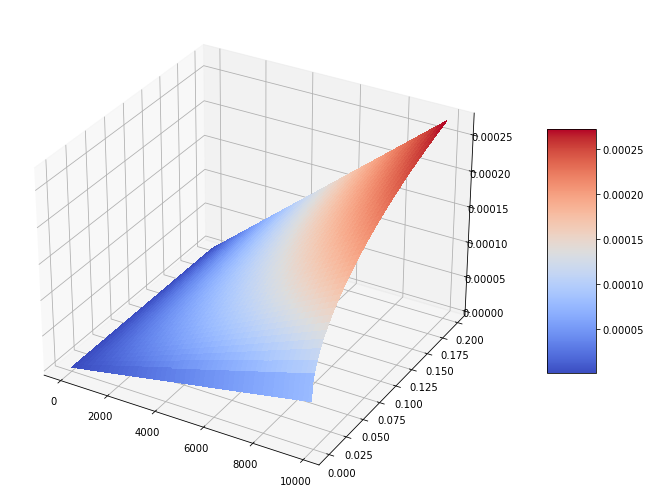

In [55]:
# plotting time
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(18,9))

manifold = ax.plot_surface(stable_bankroll, ptp_proportion, returns,
                           cmap=cm.coolwarm, linewidth=0, antialiased=False)
fig.colorbar(manifold, shrink=0.5, aspect=5)

plt.show()